In [210]:
import math
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import plotly
from plotly import tools
from plotly.offline import iplot
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM, GRU
from keras.layers import SimpleRNN
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

from pandas.core.frame import DataFrame
from matplotlib.font_manager import FontProperties 
import matplotlib

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D

import datetime
import numpy as geek 

In [211]:
def showPlot(true, prediction, model , test_set, size='M', save=False):
    if(size=='L'):
        plt.figure(figsize=(28, 10))
    plt.plot(true, color = 'red', label = 'Real')
    plt.plot(prediction, color = 'blue', label = 'Prediction')
    plt.title('Industry Elec Prediction' + model + ' ' + test_set)
    plt.xlabel('Time')
    plt.ylabel('kW')
    plt.legend()
    if(save):
        plt.savefig('Image/' + model + '-' + test_set + '.png')
    plt.show()

In [212]:
n_input = 7

#上週三到本週二
trainDateStart = '2017-01-04'
trainDateEnd = '2019-01-01'

preDateStart = '2019-01-02'
preDateEnd = '2019-09-24'

predictPeakLoad = pd.read_csv('Data/predictPeakLoad_週三到週二_1106_MAPE_2_278(訓練資料2017_2018).csv')

### 載入資料

In [213]:
df = pd.read_csv('Data/elec_merge_20160101_20190930.csv')
#將日期欄位轉為 datetime 格式。
df['日期'] = pd.to_datetime(df['日期'], format='%Y-%m-%d')

#選擇要使用的欄位
selected_features = ['工業用電(百萬度)', 'isHoliday_shift', 'dayOfYear', 'weekUpdate_shift', 'Temp_Taipei_shift', '尖峰負載(MW)']

#補星期幾
#2016年01月01日 -> 星期五 ， 2016年01月02日 -> 星期六
#2019年09月29日 -> 星期日 ， 2019年09月30日 -> 星期一
df['week'] = np.nan
week = [7, 1, 2, 3, 4, 5, 6]
while len(week)<(len(df['week'])-4):
     week = np.concatenate((week, [7, 1, 2, 3, 4, 5, 6]), axis = None)
week = np.concatenate([[5,6], week, [7,1]])

df['week'] = week
df['week_update'] = week

In [214]:
#2016年
week_column = 'week_update'
df.at[df['日期']=='2016-01-01', week_column]= 7
df.at[df['日期']=='2016-01-30', week_column]= 5

df.at[df['日期']=='2016-02-07', week_column]= 7
df.at[df['日期']=='2016-02-08', week_column]= 7
df.at[df['日期']=='2016-02-09', week_column]= 7
df.at[df['日期']=='2016-02-10', week_column]= 7
df.at[df['日期']=='2016-02-11', week_column]= 7
df.at[df['日期']=='2016-02-12', week_column]= 7

df.at[df['日期']=='2016-02-28', week_column]= 7 #不變
df.at[df['日期']=='2016-02-29', week_column]= 7
df.at[df['日期']=='2016-03-01', week_column]= 1


df.at[df['日期']=='2016-04-04', week_column]= 7
df.at[df['日期']=='2016-04-05', week_column]= 1
df.at[df['日期']=='2016-04-06', week_column]= 1

df.at[df['日期']=='2016-05-01', week_column]= 7 #不變

df.at[df['日期']=='2016-06-04', week_column]= 5

df.at[df['日期']=='2016-06-08', week_column]= 5
df.at[df['日期']=='2016-06-09', week_column]= 7
df.at[df['日期']=='2016-06-10', week_column]= 7

df.at[df['日期']=='2016-09-10', week_column]= 5

df.at[df['日期']=='2016-09-14', week_column]= 5
df.at[df['日期']=='2016-09-15', week_column]= 7
df.at[df['日期']=='2016-09-16', week_column]= 7

df.at[df['日期']=='2016-10-10', week_column]= 6
df.at[df['日期']=='2016-10-11', week_column]= 1

In [215]:
#2017年
week_column = 'week_update'
df.at[df['日期']=='2017-01-02', week_column]= 7
df.at[df['日期']=='2017-01-03', week_column]= 1

df.at[df['日期']=='2017-01-26', week_column]= 5
df.at[df['日期']=='2017-01-27', week_column]= 7
df.at[df['日期']=='2017-01-28', week_column]= 7
df.at[df['日期']=='2017-01-29', week_column]= 7
df.at[df['日期']=='2017-01-30', week_column]= 7
df.at[df['日期']=='2017-01-31', week_column]= 7
df.at[df['日期']=='2017-02-01', week_column]= 7
df.at[df['日期']=='2017-02-02', week_column]= 1

df.at[df['日期']=='2017-02-18', week_column]= 5

df.at[df['日期']=='2017-02-27', week_column]= 7
df.at[df['日期']=='2017-02-28', week_column]= 6
df.at[df['日期']=='2017-03-01', week_column]= 1

df.at[df['日期']=='2017-04-03', week_column]= 7
df.at[df['日期']=='2017-04-04', week_column]= 6
df.at[df['日期']=='2017-04-05', week_column]= 1

df.at[df['日期']=='2017-05-01', week_column]= 6
df.at[df['日期']=='2017-05-02', week_column]= 1

df.at[df['日期']=='2017-05-29', week_column]= 7
df.at[df['日期']=='2017-05-30', week_column]= 6
df.at[df['日期']=='2017-05-31', week_column]= 1

df.at[df['日期']=='2017-06-03', week_column]= 5
df.at[df['日期']=='2017-09-30', week_column]= 5

df.at[df['日期']=='2017-10-03', week_column]= 5
df.at[df['日期']=='2017-10-04', week_column]= 7
df.at[df['日期']=='2017-10-05', week_column]= 1

df.at[df['日期']=='2017-10-09', week_column]= 7
df.at[df['日期']=='2017-10-10', week_column]= 6
df.at[df['日期']=='2017-10-11', week_column]= 1

In [216]:
#2018年
week_column = 'week_update'
df.at[df['日期']=='2018-01-01', week_column]= 7
df.at[df['日期']=='2018-01-02', week_column]= 1

df.at[df['日期']=='2018-02-14', week_column]= 5
df.at[df['日期']=='2018-02-15', week_column]= 7
df.at[df['日期']=='2018-02-16', week_column]= 7
df.at[df['日期']=='2018-02-17', week_column]= 7
df.at[df['日期']=='2018-02-18', week_column]= 7
df.at[df['日期']=='2018-02-19', week_column]= 7
df.at[df['日期']=='2018-02-20', week_column]= 7
df.at[df['日期']=='2018-02-21', week_column]= 1


df.at[df['日期']=='2018-02-27', week_column]= 5
df.at[df['日期']=='2018-02-28', week_column]= 7
df.at[df['日期']=='2018-03-01', week_column]= 1

df.at[df['日期']=='2018-03-31', week_column]= 5

df.at[df['日期']=='2018-04-04', week_column]= 6
df.at[df['日期']=='2018-04-05', week_column]= 7
df.at[df['日期']=='2018-04-06', week_column]= 7
df.at[df['日期']=='2018-04-07', week_column]= 7

df.at[df['日期']=='2018-04-30', week_column]= 5
df.at[df['日期']=='2018-05-01', week_column]= 6
df.at[df['日期']=='2018-05-02', week_column]= 1

df.at[df['日期']=='2018-06-18', week_column]= 7
df.at[df['日期']=='2018-06-19', week_column]= 1

df.at[df['日期']=='2018-09-24', week_column]= 7
df.at[df['日期']=='2018-09-25', week_column]= 1

df.at[df['日期']=='2018-10-09', week_column]= 5
df.at[df['日期']=='2018-10-10', week_column]= 6
df.at[df['日期']=='2018-10-11', week_column]= 1

df.at[df['日期']=='2018-12-22', week_column]= 5
df.at[df['日期']=='2018-12-31', week_column]= 7

In [217]:
#2019年
week_column = 'week_update'
df.at[df['日期']=='2019-01-01', week_column]= 7
df.at[df['日期']=='2019-01-02', week_column]= 1

df.at[df['日期']=='2019-01-19', week_column]= 5

df.at[df['日期']=='2019-02-04', week_column]= 7
df.at[df['日期']=='2019-02-05', week_column]= 7
df.at[df['日期']=='2019-02-06', week_column]= 7
df.at[df['日期']=='2019-02-07', week_column]= 7
df.at[df['日期']=='2019-02-08', week_column]= 7
# df.at[df['日期']=='2019-02-09', week_column]= 7

df.at[df['日期']=='2019-02-23', week_column]= 5

df.at[df['日期']=='2019-02-27', week_column]= 5
df.at[df['日期']=='2019-02-28', week_column]= 7
df.at[df['日期']=='2019-03-01', week_column]= 7
# df.at[df['日期']=='2019-03-02', week_column]= 7

df.at[df['日期']=='2019-04-03', week_column]= 5
df.at[df['日期']=='2019-04-04', week_column]= 7
df.at[df['日期']=='2019-04-05', week_column]= 7
# df.at[df['日期']=='2019-04-06', week_column]= 7

df.at[df['日期']=='2019-04-30', week_column]= 5
df.at[df['日期']=='2019-05-01', week_column]= 6
df.at[df['日期']=='2019-05-02', week_column]= 1

df.at[df['日期']=='2019-06-06', week_column]= 5
df.at[df['日期']=='2019-06-07', week_column]= 7
# df.at[df['日期']=='2019-06-08', week_column]= 7

df.at[df['日期'] == '2019-09-12', week_column] = 5
df.at[df['日期'] == '2019-09-13', week_column] = 7  

### 載入大氣資料

In [218]:
atmosphericFactor = pd.read_csv('Data/FromCODIS_clean_daily_ByRegion(ElectRatio)_20160101_20191031.csv')

#位移溫度
atmosphericFactor['Temp_Taipei_shift'] = atmosphericFactor['Temp_Taipei'].shift(-7)
atmosphericFactor['Temp_Taichung_shift'] = atmosphericFactor['Temp_Taichung'].shift(-7)
atmosphericFactor['Temp_Kao_shift'] = atmosphericFactor['Temp_Kao'].shift(-7)

atmosphericFactor['Temp_avg_shift'] = atmosphericFactor['Temp_avg'].shift(-7)

#位移雨量
atmosphericFactor['Precp_Taipei_shift'] = atmosphericFactor['Precp_Taipei'].shift(-7)
atmosphericFactor['Precp_Taichung_shift'] = atmosphericFactor['Precp_Taichung'].shift(-7)
atmosphericFactor['Precp_Kao_shift'] = atmosphericFactor['Precp_Kao'].shift(-7)

atmosphericFactor['Precp_ratio_shift'] = (atmosphericFactor['Precp_Taipei']*atmosphericFactor['ElectRatio_north'] + atmosphericFactor['Precp_Taichung']*atmosphericFactor['ElectRatio_central'] + atmosphericFactor['Precp_Kao']*atmosphericFactor['ElectRatio_south']).shift(-7)
atmosphericFactor['Precp_avg_shift'] = (atmosphericFactor['Precp_Taipei_shift'] + atmosphericFactor['Precp_Taichung_shift'] + atmosphericFactor['Precp_Kao_shift'])/3 


#位移氣壓
atmosphericFactor['StnPres_Taipei_shift'] = atmosphericFactor['StnPres_Taipei'].shift(-7)
atmosphericFactor['StnPres_Taichung_shift'] = atmosphericFactor['StnPres_Taichung'].shift(-7)
atmosphericFactor['StnPres_Kao_shift'] = atmosphericFactor['StnPres_Kao'].shift(-7)

#位移濕度
atmosphericFactor['RH_Taipei_shift'] = atmosphericFactor['RH_Taipei'].shift(-7)
atmosphericFactor['RH_Taichung_shift'] = atmosphericFactor['RH_Taichung'].shift(-7)
atmosphericFactor['RH_Kao_shift'] = atmosphericFactor['RH_Kao'].shift(-7)

#位移風速
atmosphericFactor['WS_Taipei_shift'] = atmosphericFactor['WS_Taipei'].shift(-7)
atmosphericFactor['WS_Taichung_shift'] = atmosphericFactor['WS_Taichung'].shift(-7)
atmosphericFactor['WS_Kao_shift'] = atmosphericFactor['WS_Kao'].shift(-7)

atmosphericFactor = atmosphericFactor[(atmosphericFactor['Date']>='2016-01-01') & (atmosphericFactor['Date']<='2019-09-30')]

df = pd.concat([df, atmosphericFactor.iloc[:,1:]], axis=1, sort = False)

In [219]:
atmosphericFactor[['Date', 
                   'Precp_Taipei', 'ElectRatio_north',
                   'Precp_Taichung', 'ElectRatio_central',
                   'Precp_Kao', 'ElectRatio_south', 
                   'Precp_Taipei_shift', 'Precp_ratio_shift']]

,Date,Precp_Taipei,ElectRatio_north,Precp_Taichung,ElectRatio_central,Precp_Kao,ElectRatio_south,Precp_Taipei_shift,Precp_ratio_shift
0,2016-01-01,0.0,0.378203,0.0,0.266866,0.0,0.343175,4.4,4.352150
1,2016-01-02,0.6,0.378203,0.5,0.266866,11.5,0.343175,1.0,0.378203
2,2016-01-03,14.6,0.378203,27.5,0.266866,20.5,0.343175,0.0,0.000000
3,2016-01-04,1.8,0.378203,2.5,0.266866,0.0,0.343175,20.6,18.332185
4,2016-01-05,0.9,0.378203,0.0,0.266866,0.0,0.343175,20.4,8.249069
...,...,...,...,...,...,...,...,...,...
1364,2019-09-26,31.5,0.361529,0.0,0.292846,0.0,0.335931,0.0,0.000000
1365,2019-09-27,118.0,0.361529,0.0,0.292846,0.0,0.335931,0.0,0.000000
1366,2019-09-28,145.0,0.361529,0.0,0.292846,0.0,0.335931,0.0,0.000000
1367,2019-09-29,95.5,0.361529,0.0,0.292846,0.0,0.335931,0.0,0.340271


In [220]:
df['PrecpTaipeiShift_interval'] = np.nan
df['PrecpTaipeiShift_interval'] = df['PrecpTaipeiShift_interval'].fillna(0)

df.loc[df['Precp_Taipei_shift']>=80, 'PrecpTaipeiShift_interval'] = 1
df.loc[df['Precp_Taipei_shift']>=200, 'PrecpTaipeiShift_interval'] = 2
df.loc[df['Precp_Taipei_shift']>=350, 'PrecpTaipeiShift_interval'] = 3
df.loc[df['Precp_Taipei_shift']>=500, 'PrecpTaipeiShift_interval'] = 4

In [221]:
df[(df['日期']>='2017-01-01') & (df['日期']<='2019-09-30')].corr()

,尖峰負載(MW),淨尖峰供電能力(MW),備轉容量(MW),備轉容量率(%),工業用電(百萬度),民生用電(百萬度),isHoliday,isHoliday(Next7),Week,week,...,Precp_avg_shift,StnPres_Taipei_shift,StnPres_Taichung_shift,StnPres_Kao_shift,RH_Taipei_shift,RH_Kao_shift,WS_Taipei_shift,WS_Taichung_shift,WS_Kao_shift,PrecpTaipeiShift_interval
尖峰負載(MW),1.000000,0.964430,0.156419,-0.141047,0.900925,0.819954,-0.572364,-0.446227,-0.376951,-0.376951,...,0.199235,-0.587787,-0.624929,-0.627564,-0.179999,0.385744,-0.325068,0.043436,-0.071269,0.054615
淨尖峰供電能力(MW),0.964430,1.000000,0.401933,0.124020,0.835521,0.846737,-0.502982,-0.392964,-0.325787,-0.325787,...,0.220014,-0.630824,-0.668738,-0.671910,-0.174026,0.455488,-0.340207,0.055764,-0.076468,0.074986
備轉容量(MW),0.156419,0.401933,1.000000,0.913821,0.010228,0.354713,0.085851,0.067517,0.080238,0.080238,...,0.126160,-0.303264,-0.317750,-0.321537,-0.035839,0.321386,-0.145412,0.060299,-0.023614,0.094442
備轉容量率(%),-0.141047,0.124020,0.913821,1.000000,-0.266899,0.102568,0.284755,0.212969,0.206423,0.206423,...,0.085036,-0.165070,-0.169413,-0.171748,0.028226,0.260754,-0.059641,0.047707,-0.016876,0.088744
工業用電(百萬度),0.900925,0.835521,0.010228,-0.266899,1.000000,0.718544,-0.692061,-0.512639,-0.418586,-0.418586,...,0.150989,-0.383472,-0.418893,-0.421005,-0.132101,0.257209,-0.202262,0.014202,-0.071791,0.041488
民生用電(百萬度),0.819954,0.846737,0.354713,0.102568,0.718544,1.000000,-0.348741,-0.272308,-0.208724,-0.208724,...,0.208384,-0.481023,-0.547337,-0.563656,-0.102540,0.331115,-0.227437,0.085252,-0.058858,0.144116
isHoliday,-0.572364,-0.502982,0.085851,0.284755,-0.692061,-0.348741,1.000000,0.769578,0.684594,0.684594,...,0.000704,0.006978,0.011661,0.010376,0.055322,-0.006874,0.012084,0.001965,0.005553,0.023761
isHoliday(Next7),-0.446227,-0.392964,0.067517,0.212969,-0.512639,-0.272308,0.769578,1.000000,0.688345,0.688345,...,-0.027293,0.024963,0.025116,0.025474,0.028615,-0.050640,-0.013060,-0.032863,0.001986,-0.010385
Week,-0.376951,-0.325787,0.080238,0.206423,-0.418586,-0.208724,0.684594,0.688345,1.000000,1.000000,...,0.017470,-0.013757,-0.012688,-0.015523,0.037287,-0.015835,-0.022079,0.018805,0.039154,0.028190
week,-0.376951,-0.325787,0.080238,0.206423,-0.418586,-0.208724,0.684594,0.688345,1.000000,1.000000,...,0.017470,-0.013757,-0.012688,-0.015523,0.037287,-0.015835,-0.022079,0.018805,0.039154,0.028190


### 處理 ＆ 位移 其他欄位
要預測未來7天的值，故將其他欄位左移7天，並手動補足剩餘欄位的值。

In [222]:
numberOfDays_2016 = len(pd.date_range(start='2016-01-01', end='2016-12-31'))
numberOfDays_2017 = len(pd.date_range(start='2017-01-01', end='2017-12-31'))
numberOfDays_2018 = len(pd.date_range(start='2018-01-01', end='2018-12-31'))
numberOfDays_2019 = len(pd.date_range(start='2019-01-01', end='2019-09-30'))

numberOfDays = np.concatenate((np.arange(1, numberOfDays_2016+1), np.arange(1, numberOfDays_2017+1), np.arange(1,numberOfDays_2018 +1), np.arange(1,numberOfDays_2019 +1)),axis=0)
df['dayOfYear'] = numberOfDays

In [223]:
df['isHoliday_shift'] = df['isHoliday'].shift(-7)
df.loc[1362:1365, ("isHoliday_shift")] = 0
df.loc[1366:1367, ("isHoliday_shift")] = 1
df.loc[1368, ("isHoliday_shift")] = 0
# df[-10:]

In [224]:
df['尖峰負載(MW)_ori'] = df['尖峰負載(MW)']
df['尖峰負載(MW)'] = df['尖峰負載(MW)'].shift(-7)

#往前位移七天
preDateEnd_ = datetime.datetime.strptime(preDateEnd, "%Y-%m-%d")
preDateEnd_7ago = datetime.datetime(preDateEnd_.year, preDateEnd_.month, preDateEnd_.day) + datetime.timedelta(days=-7)
preDateEnd_7ago = preDateEnd_7ago.strftime("%Y-%m-%d")
preDateEnd_7ago

df.at[(df['日期']>=preDateStart) & (df['日期']<=preDateEnd), '尖峰負載(MW)']= geek.nan
df.at[(df['日期']>=preDateStart) & (df['日期']<=preDateEnd_7ago), '尖峰負載(MW)']= (predictPeakLoad['尖峰負載(MW)_predict'][7:].tolist())

for idx, val in enumerate(df['尖峰負載(MW)']):
    if(pd.isnull(val)):
        newValue = (df.loc[idx-7]['尖峰負載(MW)_ori'] + df.loc[idx-14]['尖峰負載(MW)_ori'])/2
        df.loc[idx, '尖峰負載(MW)'] = newValue

In [225]:
df['weekUpdate_shift'] = df['week_update'].shift(-7)

df.loc[1362, ("weekUpdate_shift")] = 2
df.loc[1363, ("weekUpdate_shift")] = 3
df.loc[1364, ("weekUpdate_shift")] = 4
df.loc[1365, ("weekUpdate_shift")] = 5
df.loc[1366, ("weekUpdate_shift")] = 6
df.loc[1367, ("weekUpdate_shift")] = 7
df.loc[1368, ("weekUpdate_shift")] = 1
# df[-10:]

In [226]:
df.corr()

,尖峰負載(MW),淨尖峰供電能力(MW),備轉容量(MW),備轉容量率(%),工業用電(百萬度),民生用電(百萬度),isHoliday,isHoliday(Next7),Week,week,...,RH_Taipei_shift,RH_Kao_shift,WS_Taipei_shift,WS_Taichung_shift,WS_Kao_shift,PrecpTaipeiShift_interval,dayOfYear,isHoliday_shift,尖峰負載(MW)_ori,weekUpdate_shift
尖峰負載(MW),1.000000,0.830894,0.169741,-0.074752,0.652159,0.668035,-0.429030,-0.556761,-0.364808,-0.364808,...,-0.161114,0.367681,-0.358223,0.030998,-0.044666,0.025529,0.273056,-0.556761,0.820885,-0.466991
淨尖峰供電能力(MW),0.830894,1.000000,0.290699,-0.016289,0.826711,0.837274,-0.503094,-0.391832,-0.327608,-0.327608,...,-0.174124,0.392776,-0.319097,0.044928,-0.008350,0.074516,0.337639,-0.391832,0.964358,-0.327125
備轉容量(MW),0.169741,0.290699,1.000000,0.912562,-0.100006,0.214819,0.114936,0.085454,0.079207,0.079207,...,-0.026472,0.265135,-0.120035,0.049192,-0.018615,0.082769,0.154376,0.085454,0.035824,0.055231
備轉容量率(%),-0.074752,-0.016289,0.912562,1.000000,-0.390020,-0.063028,0.303788,0.218487,0.190952,0.190952,...,0.032427,0.188138,-0.031340,0.034216,-0.027820,0.066276,0.032188,0.218487,-0.277949,0.161443
工業用電(百萬度),0.652159,0.826711,-0.100006,-0.390020,1.000000,0.706065,-0.649998,-0.479114,-0.384326,-0.384326,...,-0.128058,0.171999,-0.169660,-0.002760,-0.022040,0.051657,0.304980,-0.479114,0.891331,-0.362913
民生用電(百萬度),0.668035,0.837274,0.214819,-0.063028,0.706065,1.000000,-0.343637,-0.263411,-0.200262,-0.200262,...,-0.106558,0.318845,-0.209651,0.053127,0.009198,0.145967,0.555007,-0.263411,0.821788,-0.205957
isHoliday,-0.429030,-0.503094,0.114936,0.303788,-0.649998,-0.343637,1.000000,0.773798,0.691703,0.691703,...,0.036772,0.003191,-0.000715,-0.006195,-0.020785,0.015223,-0.043746,0.773798,-0.560359,0.618009
isHoliday(Next7),-0.556761,-0.391832,0.085454,0.218487,-0.479114,-0.263411,0.773798,1.000000,0.691337,0.691337,...,-0.013592,-0.040107,-0.041239,-0.033356,-0.007857,0.001942,-0.029404,1.000000,-0.434455,0.791959
Week,-0.364808,-0.327608,0.079207,0.190952,-0.384326,-0.200262,0.691703,0.691337,1.000000,1.000000,...,0.031323,0.008966,-0.032052,0.006185,0.018516,0.026656,0.006916,0.691337,-0.365115,0.897386
week,-0.364808,-0.327608,0.079207,0.190952,-0.384326,-0.200262,0.691703,0.691337,1.000000,1.000000,...,0.031323,0.008966,-0.032052,0.006185,0.018516,0.026656,0.006916,0.691337,-0.365115,0.897386


### 將資料集切割為 train set 與 test set

In [227]:
def split_dataset(data, split_num):
    split_num_start = df[df['日期']== trainDateStart].index.item()
    split_num = df[df['日期']== preDateStart].index.item()
    split_num_end = df[df['日期']== preDateEnd].index.item()
    train, test = data[split_num_start:split_num], data[split_num:split_num_end+1]
    # restructure into windows of weekly data
    train = np.array(np.split(train, len(train) / 7))
    test = np.array(np.split(test, len(test) / 7))
    return train, test

### 將資料分成 input (X) 與 output (y)

In [228]:
def to_supervised(train, n_input, n_out=7):
    # flatten the data
    data = train.reshape((train.shape[0] * train.shape[1], train.shape[2]))
    X, y = [], []
    in_start = 0
    for _ in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_out
        if out_end < len(data):
            x_input = data[in_start:in_end, ]
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        in_start += 1
    return np.array(X), np.array(y)

### Normalization

In [229]:
p
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    train = train.reshape(train.shape[0], train.shape[1] * train.shape[2])
    test = test.reshape(test.shape[0], test.shape[1] * test.shape[2])
    
    scaler = scaler.fit(np.concatenate((train, test)))
    
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    
    return scaler, train_scaled, test_scaled

### 建立模型

In [230]:
def build_model(train, n_input):
    train_x, train_y = to_supervised(train, n_input)
    verbose, epochs, batch_size = 1, 1000, 50
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    model = Sequential()
    model.add(SimpleRNN(200, activation='relu',
                        input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(7))
    model.add(SimpleRNN(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    earlyStop = EarlyStopping(
        monitor="val_loss", patience=20, mode="min", restore_best_weights=True)
    modelResult = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size,
                            verbose=verbose, validation_split=0.10, callbacks=[earlyStop])
    return model, modelResult

### 預測

In [231]:
def forecast(model, history, n_input):
    data = np.array(history)
    data = data.reshape((data.shape[0] * data.shape[1], data.shape[2]))
    input_x = data[-n_input:, :] #取得倒數七筆的資料
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    return model.predict(input_x, verbose=0)[0] # 要預測該週(七天)的負載，必須拿前七天來預測

### 績效評估

In [232]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def calcError(origin, forecast):
    print("RMSE", RMSE(origin, forecast))
    print("MAPE", MAPE(origin, forecast))

In [233]:
def evaluate_model(model, train, test, n_input):
    history = [x for x in train]  #train (104, 7, 2)
    predictions = []
    for i in range(len(test)): #會跑8次test (8, 7, 2)(test資料56筆資料，共8個週期)
        yhat_sequence = forecast(model, history, n_input)
        predictions.append(yhat_sequence)
        history.append(test[i, :]) #一週一週加入歷史資料
        
    t = scaler.inverse_transform(test.reshape((test.shape[0], test.shape[1] * test.shape[2])))
    t = t.reshape(t.shape[0], train.shape[1], t.shape[1] // train.shape[1])[:,:,0] #8,21, 3(21/7)
    
    predictions = np.array(predictions)
    
    predictions = np.concatenate((predictions, np.zeros((predictions.shape[0], train.shape[1], train.shape[2] - 1))),
                                 axis=2)
    predictions = predictions.reshape((predictions.shape[0], predictions.shape[1] * predictions.shape[2]))
    p = scaler.inverse_transform(predictions)
    p = p.reshape(p.shape[0], train.shape[1], p.shape[1] // train.shape[1])[:,:,0]
    
    return t, p

In [234]:
df = df[['日期'] + selected_features]
raw_data = df[selected_features].values
train, test = split_dataset(raw_data, 1092)
scaler, train, test = scale(train, test)
train = train.reshape((train.shape[0], train.shape[1] // raw_data.shape[1], raw_data.shape[1]))
test = test.reshape((test.shape[0], test.shape[1] // raw_data.shape[1], raw_data.shape[1]))

In [235]:
date_range = pd.date_range(start = preDateStart, end = preDateEnd)
predictRange = df[df['日期'].between(date_range.min(), date_range.max())].reset_index()
d = {'date': predictRange['日期'], 'truth': predictRange['工業用電(百萬度)']}
df_predictRange = pd.DataFrame(d)

### 模型建構與訓練

In [236]:
%%time
for i in range(20):
    print(i)
    model, modelResult = build_model(train, n_input)
    truth, pred = evaluate_model(model, train, test, n_input)
    truth = truth.reshape(truth.shape[0]*truth.shape[1]) 
    pred = pred.reshape(pred.shape[0]*pred.shape[1]) 
    df_predictRange['run'+ str(i+1)] = pred

0
Train on 642 samples, validate on 72 samples
Epoch 1/1000
642/642 [==============================] - 38s 59ms/step - loss: 0.1115 - val_loss: 0.0102
Epoch 2/1000
642/642 [==============================] - 0s 466us/step - loss: 0.0188 - val_loss: 0.0058
Epoch 3/1000
642/642 [==============================] - 0s 464us/step - loss: 0.0117 - val_loss: 0.0060
Epoch 4/1000
642/642 [==============================] - 0s 478us/step - loss: 0.0096 - val_loss: 0.0053
Epoch 5/1000
642/642 [==============================] - 0s 465us/step - loss: 0.0087 - val_loss: 0.0049
Epoch 6/1000
642/642 [==============================] - 0s 444us/step - loss: 0.0076 - val_loss: 0.0046
Epoch 7/1000
642/642 [==============================] - 0s 446us/step - loss: 0.0069 - val_loss: 0.0041
Epoch 8/1000
642/642 [==============================] - 0s 461us/step - loss: 0.0059 - val_loss: 0.0034
Epoch 9/1000
642/642 [==============================] - 0s 444us/step - loss: 0.0053 - val_loss: 0.0034
Epoch 10/1000
642

Epoch 17/1000
642/642 [==============================] - 0s 448us/step - loss: 0.0036 - val_loss: 0.0025
Epoch 18/1000
642/642 [==============================] - 0s 430us/step - loss: 0.0033 - val_loss: 0.0021
Epoch 19/1000
642/642 [==============================] - 0s 460us/step - loss: 0.0032 - val_loss: 0.0021
Epoch 20/1000
642/642 [==============================] - 0s 439us/step - loss: 0.0032 - val_loss: 0.0040
Epoch 21/1000
642/642 [==============================] - 0s 444us/step - loss: 0.0033 - val_loss: 0.0035
Epoch 22/1000
642/642 [==============================] - 0s 447us/step - loss: 0.0031 - val_loss: 0.0034
Epoch 23/1000
642/642 [==============================] - 0s 447us/step - loss: 0.0029 - val_loss: 0.0036
Epoch 24/1000
642/642 [==============================] - 0s 458us/step - loss: 0.0029 - val_loss: 0.0018
Epoch 25/1000
642/642 [==============================] - 0s 421us/step - loss: 0.0029 - val_loss: 0.0042
Epoch 26/1000
642/642 [==============================] 

Epoch 9/1000
642/642 [==============================] - 0s 461us/step - loss: 0.0057 - val_loss: 0.0042
Epoch 10/1000
642/642 [==============================] - 0s 469us/step - loss: 0.0057 - val_loss: 0.0039
Epoch 11/1000
642/642 [==============================] - 0s 457us/step - loss: 0.0053 - val_loss: 0.0037
Epoch 12/1000
642/642 [==============================] - 0s 459us/step - loss: 0.0045 - val_loss: 0.0030
Epoch 13/1000
642/642 [==============================] - 0s 492us/step - loss: 0.0043 - val_loss: 0.0030
Epoch 14/1000
642/642 [==============================] - 0s 450us/step - loss: 0.0042 - val_loss: 0.0030
Epoch 15/1000
642/642 [==============================] - 0s 462us/step - loss: 0.0038 - val_loss: 0.0024
Epoch 16/1000
642/642 [==============================] - 0s 462us/step - loss: 0.0037 - val_loss: 0.0025
Epoch 17/1000
642/642 [==============================] - 0s 468us/step - loss: 0.0035 - val_loss: 0.0022
Epoch 18/1000
642/642 [==============================] -

642/642 [==============================] - 0s 450us/step - loss: 0.0030 - val_loss: 0.0022
Epoch 21/1000
642/642 [==============================] - 0s 445us/step - loss: 0.0033 - val_loss: 0.0023
Epoch 22/1000
642/642 [==============================] - 0s 507us/step - loss: 0.0028 - val_loss: 0.0023
Epoch 23/1000
642/642 [==============================] - 0s 478us/step - loss: 0.0031 - val_loss: 0.0021
Epoch 24/1000
642/642 [==============================] - 0s 467us/step - loss: 0.0028 - val_loss: 0.0021
Epoch 25/1000
642/642 [==============================] - 0s 469us/step - loss: 0.0025 - val_loss: 0.0021
Epoch 26/1000
642/642 [==============================] - 0s 492us/step - loss: 0.0026 - val_loss: 0.0019
Epoch 27/1000
642/642 [==============================] - 0s 450us/step - loss: 0.0024 - val_loss: 0.0018
Epoch 28/1000
642/642 [==============================] - 0s 452us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 29/1000
642/642 [==============================] - 0s 465us/ste

Epoch 97/1000
642/642 [==============================] - 0s 475us/step - loss: 6.9191e-04 - val_loss: 0.0016
Epoch 98/1000
642/642 [==============================] - 0s 472us/step - loss: 6.3886e-04 - val_loss: 0.0016
Epoch 99/1000
642/642 [==============================] - 0s 495us/step - loss: 5.7216e-04 - val_loss: 0.0015
5
Train on 642 samples, validate on 72 samples
Epoch 1/1000
642/642 [==============================] - 40s 62ms/step - loss: 0.0960 - val_loss: 0.0095
Epoch 2/1000
642/642 [==============================] - 0s 480us/step - loss: 0.0173 - val_loss: 0.0088
Epoch 3/1000
642/642 [==============================] - 0s 448us/step - loss: 0.0126 - val_loss: 0.0066
Epoch 4/1000
642/642 [==============================] - 0s 458us/step - loss: 0.0102 - val_loss: 0.0064
Epoch 5/1000
642/642 [==============================] - 0s 456us/step - loss: 0.0090 - val_loss: 0.0051
Epoch 6/1000
642/642 [==============================] - 0s 444us/step - loss: 0.0080 - val_loss: 0.0051
Ep

642/642 [==============================] - 0s 417us/step - loss: 0.0049 - val_loss: 0.0037
Epoch 12/1000
642/642 [==============================] - 0s 452us/step - loss: 0.0048 - val_loss: 0.0030
Epoch 13/1000
642/642 [==============================] - 0s 453us/step - loss: 0.0042 - val_loss: 0.0027
Epoch 14/1000
642/642 [==============================] - 0s 437us/step - loss: 0.0040 - val_loss: 0.0032
Epoch 15/1000
642/642 [==============================] - 0s 460us/step - loss: 0.0038 - val_loss: 0.0026
Epoch 16/1000
642/642 [==============================] - 0s 453us/step - loss: 0.0034 - val_loss: 0.0025
Epoch 17/1000
642/642 [==============================] - 0s 450us/step - loss: 0.0034 - val_loss: 0.0025
Epoch 18/1000
642/642 [==============================] - 0s 429us/step - loss: 0.0032 - val_loss: 0.0023
Epoch 19/1000
642/642 [==============================] - 0s 463us/step - loss: 0.0029 - val_loss: 0.0020
Epoch 20/1000
642/642 [==============================] - 0s 445us/ste

Epoch 34/1000
642/642 [==============================] - 0s 460us/step - loss: 0.0021 - val_loss: 0.0017
Epoch 35/1000
642/642 [==============================] - 0s 477us/step - loss: 0.0020 - val_loss: 0.0021
Epoch 36/1000
642/642 [==============================] - 0s 487us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 37/1000
642/642 [==============================] - 0s 483us/step - loss: 0.0017 - val_loss: 0.0022
Epoch 38/1000
642/642 [==============================] - 0s 459us/step - loss: 0.0019 - val_loss: 0.0019
Epoch 39/1000
642/642 [==============================] - 0s 481us/step - loss: 0.0020 - val_loss: 0.0031
Epoch 40/1000
642/642 [==============================] - 0s 479us/step - loss: 0.0026 - val_loss: 0.0023
Epoch 41/1000
642/642 [==============================] - 0s 464us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 42/1000
642/642 [==============================] - 0s 485us/step - loss: 0.0018 - val_loss: 0.0022
Epoch 43/1000
642/642 [==============================] 

642/642 [==============================] - 0s 453us/step - loss: 0.0012 - val_loss: 0.0018
Epoch 49/1000
642/642 [==============================] - 0s 451us/step - loss: 0.0012 - val_loss: 0.0022
Epoch 50/1000
642/642 [==============================] - 0s 477us/step - loss: 0.0013 - val_loss: 0.0016
Epoch 51/1000
642/642 [==============================] - 0s 469us/step - loss: 0.0013 - val_loss: 0.0020
Epoch 52/1000
642/642 [==============================] - 0s 475us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 53/1000
642/642 [==============================] - 0s 448us/step - loss: 0.0010 - val_loss: 0.0017
Epoch 54/1000
642/642 [==============================] - 0s 451us/step - loss: 9.1686e-04 - val_loss: 0.0021
Epoch 55/1000
642/642 [==============================] - 0s 447us/step - loss: 0.0010 - val_loss: 0.0020
Epoch 56/1000
642/642 [==============================] - 0s 455us/step - loss: 0.0010 - val_loss: 0.0017
Epoch 57/1000
642/642 [==============================] - 0s 494us

Epoch 53/1000
642/642 [==============================] - 0s 493us/step - loss: 0.0011 - val_loss: 0.0014
Epoch 54/1000
642/642 [==============================] - 0s 515us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 55/1000
642/642 [==============================] - 0s 467us/step - loss: 9.8319e-04 - val_loss: 0.0015
Epoch 56/1000
642/642 [==============================] - 0s 455us/step - loss: 9.0767e-04 - val_loss: 0.0016
Epoch 57/1000
642/642 [==============================] - 0s 470us/step - loss: 0.0011 - val_loss: 0.0017
Epoch 58/1000
642/642 [==============================] - 0s 438us/step - loss: 0.0010 - val_loss: 0.0016
11
Train on 642 samples, validate on 72 samples
Epoch 1/1000
642/642 [==============================] - 42s 66ms/step - loss: 0.0628 - val_loss: 0.0068
Epoch 2/1000
642/642 [==============================] - 0s 482us/step - loss: 0.0150 - val_loss: 0.0085
Epoch 3/1000
642/642 [==============================] - 0s 475us/step - loss: 0.0108 - val_loss: 0.0056
Ep

642/642 [==============================] - 0s 498us/step - loss: 0.0046 - val_loss: 0.0029
Epoch 15/1000
642/642 [==============================] - 0s 467us/step - loss: 0.0042 - val_loss: 0.0031
Epoch 16/1000
642/642 [==============================] - 0s 462us/step - loss: 0.0038 - val_loss: 0.0033
Epoch 17/1000
642/642 [==============================] - 0s 501us/step - loss: 0.0038 - val_loss: 0.0031
Epoch 18/1000
642/642 [==============================] - 0s 468us/step - loss: 0.0036 - val_loss: 0.0027
Epoch 19/1000
642/642 [==============================] - 0s 450us/step - loss: 0.0038 - val_loss: 0.0032
Epoch 20/1000
642/642 [==============================] - 0s 493us/step - loss: 0.0037 - val_loss: 0.0024
Epoch 21/1000
642/642 [==============================] - 0s 467us/step - loss: 0.0030 - val_loss: 0.0025
Epoch 22/1000
642/642 [==============================] - 0s 475us/step - loss: 0.0027 - val_loss: 0.0024
Epoch 23/1000
642/642 [==============================] - 0s 503us/ste

642/642 [==============================] - 0s 492us/step - loss: 6.9113e-04 - val_loss: 0.0021
Epoch 69/1000
642/642 [==============================] - 0s 492us/step - loss: 7.0834e-04 - val_loss: 0.0022
Epoch 70/1000
642/642 [==============================] - 0s 523us/step - loss: 6.7111e-04 - val_loss: 0.0022
Epoch 71/1000
642/642 [==============================] - 0s 486us/step - loss: 0.0010 - val_loss: 0.0018
Epoch 72/1000
642/642 [==============================] - 0s 495us/step - loss: 0.0016 - val_loss: 0.0024
Epoch 73/1000
642/642 [==============================] - 0s 482us/step - loss: 0.0014 - val_loss: 0.0019
Epoch 74/1000
642/642 [==============================] - 0s 457us/step - loss: 9.5624e-04 - val_loss: 0.0018
Epoch 75/1000
642/642 [==============================] - 0s 479us/step - loss: 7.1631e-04 - val_loss: 0.0018
Epoch 76/1000
642/642 [==============================] - 0s 507us/step - loss: 6.3656e-04 - val_loss: 0.0018
Epoch 77/1000
642/642 [======================

642/642 [==============================] - 0s 467us/step - loss: 3.1393e-04 - val_loss: 0.0017
Epoch 144/1000
642/642 [==============================] - 0s 464us/step - loss: 3.5561e-04 - val_loss: 0.0021
15
Train on 642 samples, validate on 72 samples
Epoch 1/1000
642/642 [==============================] - 45s 70ms/step - loss: 0.1042 - val_loss: 0.0248
Epoch 2/1000
642/642 [==============================] - 0s 495us/step - loss: 0.0187 - val_loss: 0.0083
Epoch 3/1000
642/642 [==============================] - 0s 441us/step - loss: 0.0124 - val_loss: 0.0064
Epoch 4/1000
642/642 [==============================] - 0s 488us/step - loss: 0.0102 - val_loss: 0.0058
Epoch 5/1000
642/642 [==============================] - 0s 459us/step - loss: 0.0088 - val_loss: 0.0055
Epoch 6/1000
642/642 [==============================] - 0s 482us/step - loss: 0.0078 - val_loss: 0.0049
Epoch 7/1000
642/642 [==============================] - 0s 496us/step - loss: 0.0069 - val_loss: 0.0045
Epoch 8/1000
642/64

642/642 [==============================] - 0s 490us/step - loss: 0.0038 - val_loss: 0.0023
Epoch 20/1000
642/642 [==============================] - 0s 496us/step - loss: 0.0036 - val_loss: 0.0033
Epoch 21/1000
642/642 [==============================] - 0s 491us/step - loss: 0.0032 - val_loss: 0.0023
Epoch 22/1000
642/642 [==============================] - 0s 499us/step - loss: 0.0028 - val_loss: 0.0024
Epoch 23/1000
642/642 [==============================] - 0s 466us/step - loss: 0.0025 - val_loss: 0.0023
Epoch 24/1000
642/642 [==============================] - 0s 498us/step - loss: 0.0026 - val_loss: 0.0020
Epoch 25/1000
642/642 [==============================] - 0s 465us/step - loss: 0.0023 - val_loss: 0.0018
Epoch 26/1000
642/642 [==============================] - 0s 477us/step - loss: 0.0021 - val_loss: 0.0019
Epoch 27/1000
642/642 [==============================] - 0s 471us/step - loss: 0.0020 - val_loss: 0.0019
Epoch 28/1000
642/642 [==============================] - 0s 458us/ste

Epoch 49/1000
642/642 [==============================] - 0s 508us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 50/1000
642/642 [==============================] - 0s 477us/step - loss: 0.0014 - val_loss: 0.0021
Epoch 51/1000
642/642 [==============================] - 0s 489us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 52/1000
642/642 [==============================] - 0s 499us/step - loss: 0.0014 - val_loss: 0.0019
Epoch 53/1000
642/642 [==============================] - 0s 474us/step - loss: 0.0012 - val_loss: 0.0018
Epoch 54/1000
642/642 [==============================] - 0s 501us/step - loss: 0.0012 - val_loss: 0.0026
Epoch 55/1000
642/642 [==============================] - 0s 520us/step - loss: 0.0011 - val_loss: 0.0020
Epoch 56/1000
642/642 [==============================] - 0s 508us/step - loss: 0.0011 - val_loss: 0.0021
Epoch 57/1000
642/642 [==============================] - 0s 495us/step - loss: 0.0010 - val_loss: 0.0017
Epoch 58/1000
642/642 [==============================] 

In [237]:
df_predictRange['rowsMean'] = df_predictRange[['run1','run2','run3','run4','run5']].mean(axis=1)

In [238]:
truth = df_predictRange['truth']
pred = df_predictRange['rowsMean']

calcError(truth, pred)
ground_truth = go.Scatter(x=date_range, y=truth, name='truth')
predict_answer = go.Scatter(x=date_range, y=pred, name='predict')
layout = go.Layout(
    title = '預測值 vs 實際值',
    xaxis = dict(title = '日期'),
    yaxis = dict(title = '工業用電（百萬度）')
)
fig = go.Figure(data=[ground_truth, predict_answer], layout=layout)
iplot(fig)

RMSE 9.167076084195656
MAPE 2.0872360101028358


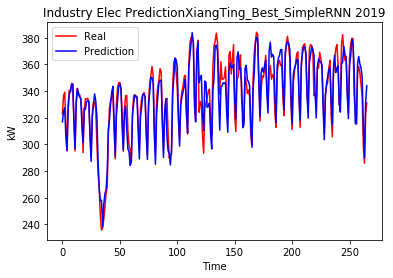

In [239]:
showPlot(truth, pred, 'XiangTing_Best_SimpleRNN' , '2019', save=True)

### 計算各特殊日的 MAPE 與 RMSE

In [240]:
holiday_0202_0210 = (
    df_predictRange['date'] >= '2019-02-02') & (df_predictRange['date'] <= '2019-02-10')
holiday_0228_0303 = (
    df_predictRange['date'] >= '2019-02-28') & (df_predictRange['date'] <= '2019-03-03')
holiday_0404_0407 = (
    df_predictRange['date'] >= '2019-04-04') & (df_predictRange['date'] <= '2019-04-07')
holiday_0501 = (
    df_predictRange['date'] >= '2019-05-01') & (df_predictRange['date'] <= '2019-05-01')
holiday_0607_0609 = (
    df_predictRange['date'] >= '2019-06-07') & (df_predictRange['date'] <= '2019-06-09')
holiday_0913_0915 = (
    df_predictRange['date'] >= '2019-09-13') & (df_predictRange['date'] <= '2019-09-15')

# 計算春節
df_temp = df_predictRange[holiday_0202_0210]
print("春節")
calcError(df_temp['truth'], df_temp['rowsMean'])

# 計算228
df_temp = df_predictRange[holiday_0228_0303]
print("228假期")
calcError(df_temp['truth'], df_temp['rowsMean'])

# 計算清明
df_temp = df_predictRange[holiday_0404_0407]
print("清明假期")
calcError(df_temp['truth'], df_temp['rowsMean'])

# 計算勞動節
df_temp = df_predictRange[holiday_0501]
print("勞動節")
calcError(df_temp['truth'], df_temp['rowsMean'])

# 計算端午
df_temp = df_predictRange[holiday_0607_0609]
print("端午假期")
calcError(df_temp['truth'], df_temp['rowsMean'])

# 計算中秋
df_temp = df_predictRange[holiday_0913_0915]
print("中秋假期")
calcError(df_temp['truth'], df_temp['rowsMean'])


# 沒有排除特殊日（最原始績效）
print("沒有排除特殊日（最原始績效）")
calcError(df_predictRange['truth'], df_predictRange['rowsMean'])

# 排除所有特殊日
excludeHolidays = ~holiday_0202_0210 & ~holiday_0228_0303 & ~holiday_0404_0407 & ~holiday_0501 & ~holiday_0607_0609 & ~holiday_0913_0915
df_excludeHolidays = df_predictRange[excludeHolidays]
print("排除所有特殊日")
calcError(df_excludeHolidays['truth'], df_excludeHolidays['rowsMean'])

春節
RMSE 10.937462965960945
MAPE 3.5519185339243884
228假期
RMSE 9.601477901339962
MAPE 2.674152130621053
清明假期
RMSE 7.998002539853461
MAPE 2.3369714641763975
勞動節
RMSE 22.115043218612698
MAPE 6.823545650746437
端午假期
RMSE 9.40911934092873
MAPE 2.5727795195722156
中秋假期
RMSE 13.168843442282622
MAPE 3.0837508348529132
沒有排除特殊日（最原始績效）
RMSE 9.167076084195656
MAPE 2.0872360101028358
排除所有特殊日
RMSE 8.948240036878628
MAPE 1.9809912429290213


### 各特殊日使用各適合模型預測出的值取代

In [241]:
df_update = df_predictRange
df_update.at[df_update[holiday_0202_0210].index.tolist(), 'rowsMean'] = [296.2685916606903,
                                                                         268.6551230596378,
                                                                         266.62611725019514,
                                                                         233.78048832652811,
                                                                         237.5939330392182,
                                                                         252.12632702508387,
                                                                         256.88761248559956,
                                                                         256.1430988708258,
                                                                         277.09936551484464]


df_update.at[df_update[holiday_0228_0303].index.tolist(), 'rowsMean'] = [
    315.53475376279357, 299.0515551307678, 279.6674245712996, 287.78825150981544]

df_update.at[df_update[holiday_0501].index.tolist(), 'rowsMean'] = [
    327.4281960201264]
df_update.at[df_update[holiday_0607_0609].index.tolist(), 'rowsMean'] = [
    356.92780619964606, 324.89612232303625, 319.65093342745297]
df_update.at[df_update[holiday_0913_0915].index.tolist(), 'rowsMean'] = [
    362.11747525558474, 323.0216351282596, 320.375536335349]

In [242]:
truth = df_update['truth']
pred = df_update['rowsMean']

calcError(truth, pred)
ground_truth = go.Scatter(x=date_range, y=truth, name='truth')
predict_answer = go.Scatter(x=date_range, y=pred, name='predict')
layout = go.Layout(
    title = '預測值 vs 實際值',
    xaxis = dict(title = '日期'),
    yaxis = dict(title = '工業用電（百萬度）')
)
fig = go.Figure(data=[ground_truth, predict_answer], layout=layout)
iplot(fig)

RMSE 9.106896641759356
MAPE 2.034209765762037


C:\Users\siang\Anaconda3\envs\tensorflow-gpu\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning:

Glyph 26367 missing from current font.

C:\Users\siang\Anaconda3\envs\tensorflow-gpu\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning:

Glyph 25563 missing from current font.

C:\Users\siang\Anaconda3\envs\tensorflow-gpu\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning:

Glyph 26367 missing from current font.

C:\Users\siang\Anaconda3\envs\tensorflow-gpu\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning:

Glyph 25563 missing from current font.



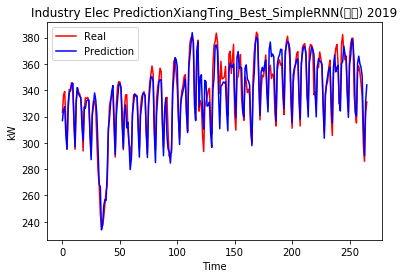

In [243]:
showPlot(truth, pred, 'XiangTing_Best_SimpleRNN(替換)' , '2019', save=True)